In [1]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-22

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
Lsolid = np.array([30.0,30.0,30.0])
print('Solid dimensions: ', Lsolid)
Vsolid = Lsolid[0]*Lsolid[1]*Lsolid[2]
print('Solid volume: ', )

Solid dimensions:  [30. 30. 30.]
Solid volume: 


# Force Field for solid-fluid interaction

In [4]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [5]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043

In [6]:
#Helium parameters for pycnometer
epsilonHe = 10.22 # kelvin
sigmaHe = 2.58  # angstrom

# Create the DFT object

In [26]:
Nsolid = 64

In [67]:
DFT = dft3d(gridsize=np.array([Nsolid,Nsolid,Nsolid]),ljmethod='WDA',padding=True,padding_value='bulk')
# DFT = dft3d(gridsize=np.array([Nsolid,Nsolid,Nsolid]),ljmethod='WDA',padding=False)
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)
DFT.Set_Geometry(Lsolid)

In [68]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
The grid is [109 109 109]
--- Geometry properties ---
Lx = 50.682104  A
Ly = 50.682104  A
Lz = 50.682104  A
delta =  [0.46875 0.46875 0.46875]  A
Vol = 130185.88723973125  A³


In [69]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


In [70]:
Vext = np.zeros((DFT.Ngrid[0],DFT.Ngrid[1],DFT.Ngrid[2]))

DFT.Set_External_Potential(Vext)

## Defining the Temperature

In [71]:
kT = 298.0 # kelvin 
DFT.Set_Temperature(kT)

In [72]:
DFT.GetFluidTemperatureInformation()

Temperature = 298.0  K
Baker-Henderson diameter = 3.568  A


In [73]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [74]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [75]:
# pbararray = np.hstack((np.array([1e-4,1e-3,1e-2]),np.arange(0.05,2.0,0.05),np.arange(2.,101,1.0),np.arange(110,510,10.0),np.arange(600,1100,100.0))) # bulk pressure (in bar)
pbararray = np.hstack((np.arange(0.05,2.0,0.05),np.arange(2.,101,1.0),np.arange(110,510,10.0))) # bulk pressure (in bar)

In [76]:
rhobarray = rhofromBARpressure(pbararray)

In [77]:
bulkMC = pd.read_pickle('methane_300K.pickle')

(0.0, 500.0)

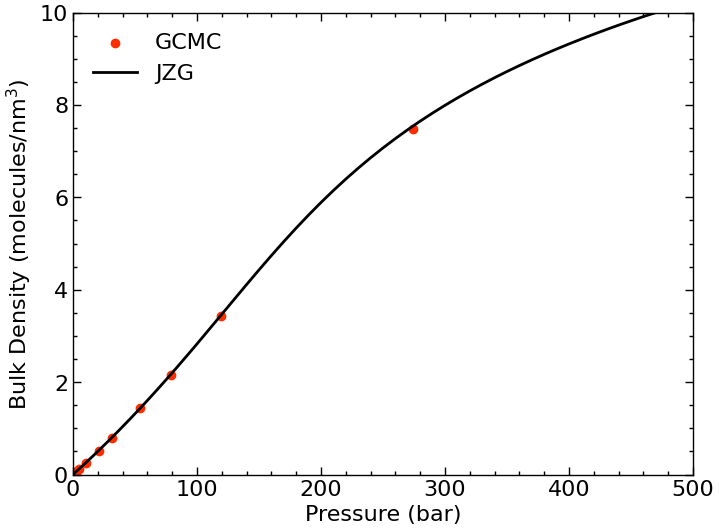

In [78]:
plt.scatter(bulkMC['Pressure (bar)'],bulkMC['Density (kg/m3)']*(NA*1e-27)/(1e-3*mff),color='C3',label='GCMC')
plt.plot(pbararray,rhobarray*1e3,color='k',label='JZG')
plt.xlabel(r'Pressure (bar)')
plt.ylabel(r'Bulk Density (molecules/nm$^{3}$)')
plt.legend(loc='best')
plt.ylim(0,10)
plt.xlim(0,500)
# plt.xscale('log')
# plt.yscale('log')

In [79]:
%%time

Omegaarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nbulk(molecules/u.c.)\t Nid(molecules/u.c.)\t Nabs(molecules/u.c.)\t Nexc(molecules/u.c.)\t dt')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)
    # DFT.Set_InitialCondition()

    DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,method='fire',logoutput=False)
    # DFT.Calculate_Equilibrium(method='rkf2(3)',logoutput=False)

    Omegaarray[i] = DFT.Omega
    print(pbararray[i].round(3),rhob,(-1e-5*kB*Omegaarray[i]/(1e-30*Vsolid)).round(4))

P (bar)	 rhob (AA^-3)	 Nbulk(molecules/u.c.)	 Nid(molecules/u.c.)	 Nabs(molecules/u.c.)	 Nexc(molecules/u.c.)	 dt
0.05 1.215362540699416e-06 0.247
0.1 2.430923153022343e-06 0.4867
0.15 3.6466818505187545e-06 0.7259
0.2 4.8626386467451845e-06 0.973
0.25 6.078793555264702e-06 1.2219
0.3 7.295146589646877e-06 1.4711
0.35 8.511697763467753e-06 1.72
0.4 9.72844709030981e-06 1.9686
0.45 1.0945394583761948e-05 2.2168
0.5 1.2162540257419439e-05 2.4648
0.55 1.3379884124883905e-05 2.7124
0.6 1.4597426199763286e-05 2.96
0.65 1.581516649567182e-05 3.2075
0.7 1.7033105026229973e-05 3.4547
0.75 1.825124180506446e-05 3.7021
0.8 1.9469576845808183e-05 3.9493
0.85 2.068811016210021e-05 4.1966
0.9 2.190684176758571e-05 4.4437
0.95 2.3125771675915984e-05 4.6909
1.0 2.434489990074838e-05 4.938
1.05 2.5564226455746283e-05 5.1851
1.1 2.678375135457908e-05 5.4322
1.15 2.800347461092213e-05 5.6794
1.2 2.9223396238456706e-05 5.9265
1.25 3.0443516250870015e-05 6.1735
1.3 3.166383466185512e-05 6.4207
1.35 3.2884

In [ ]:
DFT.Vol

27000.0

(0.0, 500.0)

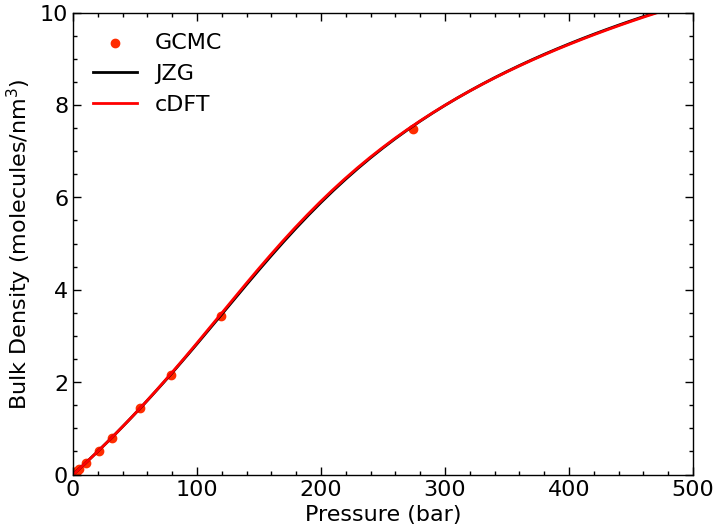

In [ ]:
plt.scatter(bulkMC['Pressure (bar)'],bulkMC['Density (kg/m3)']*(NA*1e-27)/(1e-3*mff),color='C3',label='GCMC')
plt.plot(pbararray,rhobarray*1e3,color='k',label='JZG')
plt.plot(-1e-5*kB*Omegaarray/(1e-30*DFT.Vol),rhobarray*1e3,color='r',label='cDFT')
plt.xlabel(r'Pressure (bar)')
plt.ylabel(r'Bulk Density (molecules/nm$^{3}$)')
plt.legend(loc='best')
plt.ylim(0,10)
plt.xlim(0,500)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
rhomax = DFT.rho[:,:,:].max().numpy()

In [ ]:
DFT.rho[0,0,0]

tensor(0.0103)

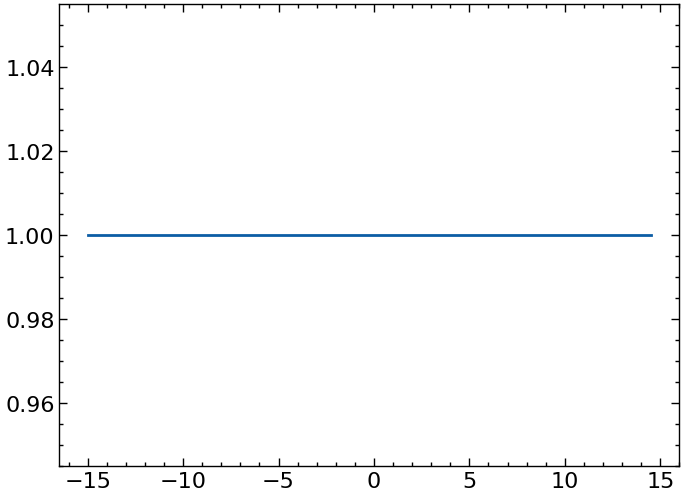

In [ ]:
plt.plot(DFT.X[:,DFT.Ngrid[1]//2,DFT.Ngrid[2]//2],DFT.rho[:,DFT.Ngrid[1]//2,DFT.Ngrid[2]//2].cpu()/rhob)

AttributeError: 'dft3d' object has no attribute 'Npad'

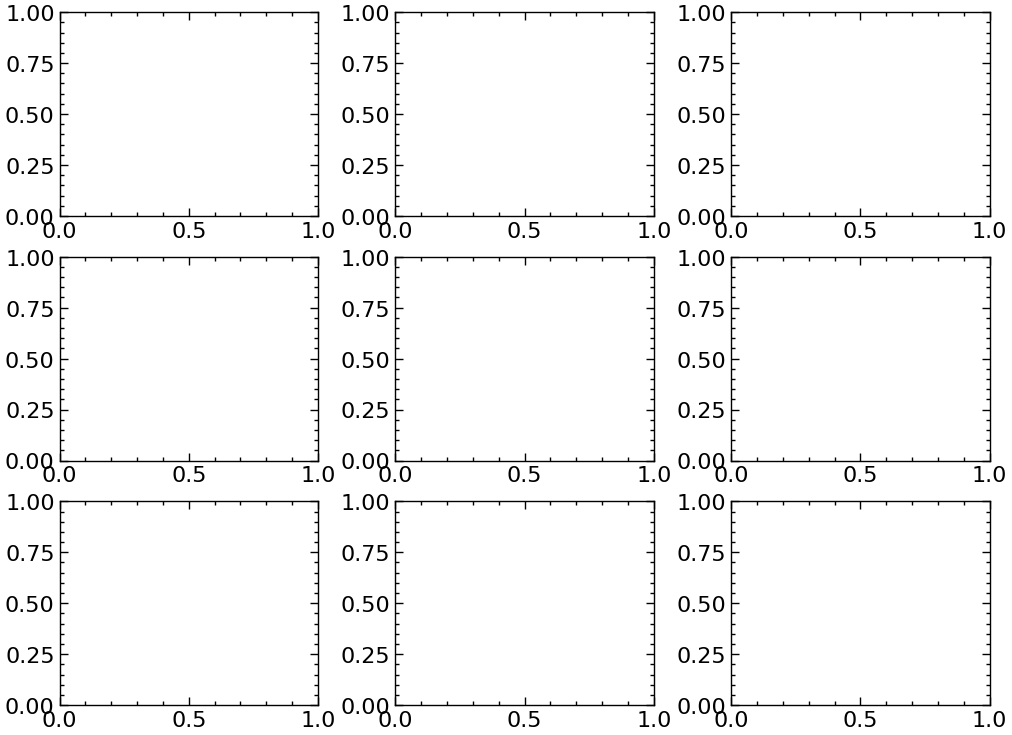

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
plt.subplots_adjust(hspace=0.2,wspace=0.3)

colormp = 'afmhot'

axs[0,0].pcolormesh(DFT.X[:,:,DFT.Npad[2]+1],DFT.Y[:,:,DFT.Npad[2]+1],DFT.rho[:,:,DFT.Npad[2]+1].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[0,1].pcolormesh(DFT.X[:,:,DFT.Ngrid[2]//2],DFT.Y[:,:,DFT.Ngrid[2]//2],DFT.rho[:,:,DFT.Ngrid[2]//2].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[0,2].pcolormesh(DFT.X[:,:,-(DFT.Npad[2]+1)],DFT.Y[:,:,-(DFT.Npad[2]+1)],DFT.rho[:,:,-(DFT.Npad[2]+1)].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,0].pcolormesh(DFT.Y[(DFT.Npad[0]+1),:,:],DFT.Z[(DFT.Npad[0]+1),:,:],DFT.rho[(DFT.Npad[0]+1),:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,1].pcolormesh(DFT.Y[DFT.Ngrid[0]//2,:,:],DFT.Z[DFT.Ngrid[0]//2,:,:],DFT.rho[DFT.Ngrid[0]//2,:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,2].pcolormesh(DFT.Y[-(DFT.Npad[0]+1),:,:],DFT.Z[-(DFT.Npad[0]+1),:,:],DFT.rho[-(DFT.Npad[0]+1),:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,0].pcolormesh(DFT.X[:,(DFT.Npad[1]+1),:],DFT.Z[:,(DFT.Npad[1]+1),:],DFT.rho[:,(DFT.Npad[1]+1),:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,1].pcolormesh(DFT.X[:,DFT.Ngrid[1]//2,:],DFT.Z[:,DFT.Ngrid[1]//2,:],DFT.rho[:,DFT.Ngrid[1]//2,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,2].pcolormesh(DFT.X[:,-(DFT.Npad[1]+1),:],DFT.Z[:,-(DFT.Npad[1]+1),:],DFT.rho[:,-(DFT.Npad[1]+1),:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)